<a href="https://colab.research.google.com/github/mariamfekry/Speech-emotion-recognition/blob/main/Copy_of_Copy_of_recent_speech_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import librosa as lr
import librosa.display
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/KaggleToken"

In [ ]:
%cd /content/sample_data
!mkdir data
%cd /content/gdrive/MyDrive/KaggleToken

/content/sample_data
/content/gdrive/MyDrive/KaggleToken


In [ ]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

speech-emotion-recognition-en.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip speech-emotion-recognition-en.zip -d /content/sample_data/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/sample_data/data/Crema/1088_IWW_FEA_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_IWW_HAP_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_IWW_NEU_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_IWW_SAD_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_ANG_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_DIS_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_FEA_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_HAP_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_NEU_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_MTI_SAD_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_TAI_ANG_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_TAI_DIS_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_TAI_FEA_XX.wav  
  inflating: /content/sample_data/data/Crema/1088_TAI_HAP_XX.wav  
  inflating

In [ ]:
def LoadAudio(Crema):
    emotions = []
    timeLines=[]
    Audio_List=[]
    samp_freq=[]
    
    for wav in os.listdir(Crema):
        path=Crema+"/"+wav
        audio,sampling_freq=lr.load(path,sr=16000)
        yt, index = librosa.effects.trim(audio, top_db=60)       
        

        if len(yt) > (3*16000):
            yt = yt[:3*16000]
        else:
            padding = (3*16000) - len(yt)
            offset = padding // 2
            yt = np.pad(yt, (offset,3*16000- len(yt) - offset), 'constant')
        # yt=lr.util.normalize(yt)  

        mean = np.mean(yt)
        std = np.std(yt)
        out = np.ones( (len(yt)) ) 
        yt= np.divide((yt - mean),std,out=out, where=std!=0)
        # yt = (yt - mean) / std #normalization & standarization
        Audio_List.append(yt)
        samp_freq.append(sampling_freq)
        timeLines.append(np.arange(0,len(yt))/sampling_freq)
        info = wav.partition(".wav")[0].split("_")
        if info[2] == 'SAD':
            emotions.append(0)
        elif info[2] == 'ANG':
            emotions.append(1)
        elif info[2] == 'DIS':
            emotions.append(2)
        elif info[2] == 'FEA':
            emotions.append(3)
        elif info[2] == 'HAP':
            emotions.append(4)
        elif info[2] == 'NEU':
            emotions.append(5)
        else:
            emotions.append(6)
            
    return Audio_List,timeLines,samp_freq,emotions

In [ ]:
Audio_List,timeLines,samp_freq,Labels= LoadAudio("/content/sample_data/data/Crema")
print(len(Audio_List))
print(len(timeLines))
print(len(Labels)) 

7442
7442
7442


In [ ]:
print(lr.get_duration(Audio_List[0]))
print(lr.get_duration(Audio_List[1]))
print(lr.get_duration(Audio_List[2]))
print(Audio_List[0])
print(Audio_List[1])
print(Audio_List[2])
print(len(Audio_List[1]))
print(len(Audio_List[2]))

# if len(Audio_List[1])<len(Audio_List[2]):
#   for n in range(len(Audio_List[1]), 60000):
#     Audio_List[1].append(0)
# print(len(Audio_List[1]))
# print(len(Audio_List[2]))


2.17687074829932
2.17687074829932
2.17687074829932
[0.00036729 0.00036729 0.00036729 ... 0.00036729 0.00036729 0.00036729]
[ 1.10366333  1.04888499  1.0950141  ... -0.35228875 -0.34075645
 -0.43878093]
[0.00203603 0.00203603 0.00203603 ... 0.00203603 0.00203603 0.00203603]
48000
48000


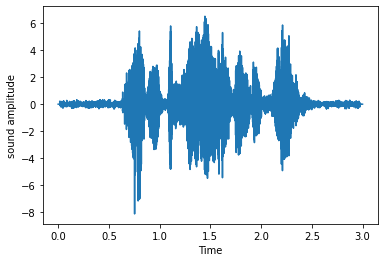

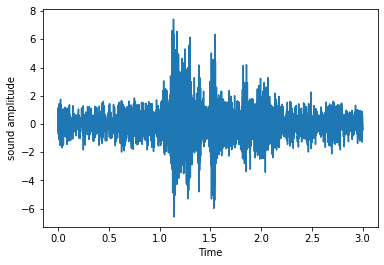

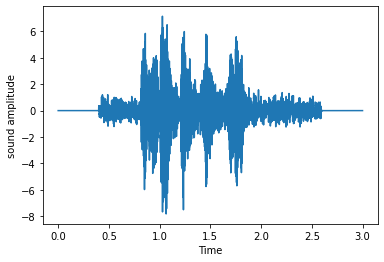

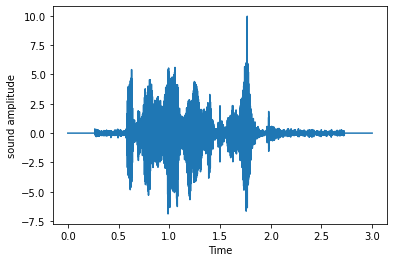

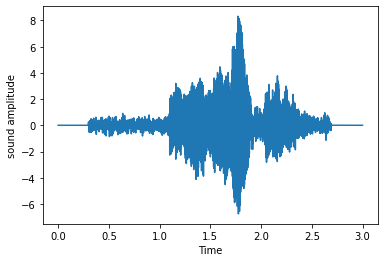

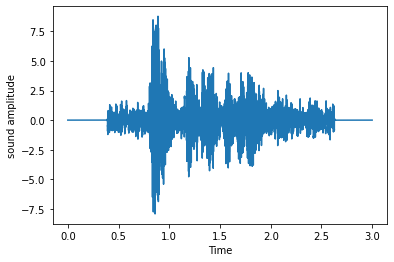

In [ ]:
#play first ten audio and plot them 
for j in range(0,6):
    fig,ax=plt.subplots()
    ax.plot(timeLines[j],Audio_List[j])
    ax.set(xlabel='Time',ylabel='sound amplitude')
    plt.show()
    #sd.play(Audio_List[j], samp_freq[j])


mel spectrogram and augmentation

In [ ]:
 trainSet,testSet, labels_train, labels_test = train_test_split(Audio_List, Labels, test_size=0.30, random_state=42)
 print(len(trainSet))
 print(len(testSet))
 trainSet, valSet, labels_train, labels_val = train_test_split(trainSet, labels_train, test_size=0.05, random_state=42)
 print(len(trainSet))
 print(len(valSet))

5209
2233
4948
261


In [ ]:
# def noise(data):
#     """
#     Adding White Noise.
#     """
#     # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
#     noise_amp = 0.005*np.random.uniform()*np.amax(data)
#     data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
#     return data

In [ ]:
train_Aug=[]
for i in range(len(trainSet)):
  train_Aug.append(trainSet[i])

# for i in range(len(trainSet)):

#   # noise_data = noise(trainSet[i])
#   train_Aug.append(noise_data)
#   labels_train.append(labels_train[i])

# print(len(train_Aug))
# print(len(labels_train))
# print(len(trainSet))

In [ ]:
# import matplotlib
# matplotlib.use('TKAgg')
# from specAugment import spec_augment_tensorflow

def mel_spectogram(Audio_List):
  S = lr.feature.melspectrogram(Audio_List, sr=16000, n_fft=2048, hop_length=512, n_mels=128)
  # warped_masked_spectrogram = spec_augment_tensorflow.spec_augment(mel_spectrogram=S)
  # S_DB = lr.power_to_db(S, ref=np.max)
  # librosa.display.specshow(S_DB, sr=22050, hop_length=512, x_axis='time', y_axis='mel');
  # plt.colorbar(format='%+2.0f dB');
  return S

In [ ]:
train_set_spectorgram = np.zeros((len(train_Aug),128,94)) # mel spectrogram training 
for audio in range(len(train_Aug)):
  train_set_spectorgram[audio] = mel_spectogram(np.array(train_Aug[audio]))
  # print(mel_specto)
  # print(mel_specto.shape)

In [ ]:
val_set_spectorgram = np.zeros((len(valSet),128,94))  # mel spectrogram val 
for audio in range(len(valSet)):
  val_set_spectorgram[audio] = mel_spectogram(np.array(valSet[audio]))
  # print(mel_specto)
  # print(mel_specto.shape)

In [ ]:
test_set_spectorgram = np.zeros((len(testSet),128,94))  # mel spectrogram test 
for audio in range(len(testSet)):
  test_set_spectorgram[audio] = mel_spectogram(np.array(testSet[audio]))
  # print(mel_specto)
  # print(mel_specto.shape)

In [ ]:
train_set_spectorgram = train_set_spectorgram[:,:,:,np.newaxis]
print(train_set_spectorgram.shape)
val_set_spectorgram = val_set_spectorgram[:,:,:,np.newaxis]
print(val_set_spectorgram.shape)
test_set_spectorgram = test_set_spectorgram[:,:,:,np.newaxis]
print(test_set_spectorgram.shape)

(4948, 128, 94, 1)
(261, 128, 94, 1)
(2233, 128, 94, 1)


In [ ]:
# def split_train_test(data_set_spectorgram,Labels):
#   mel_spectogram_train, mel_spectogram_test, labels_train, labels_test = train_test_split(data_set_spectorgram, Labels, test_size=0.30, random_state=42)
#   print(mel_spectogram_train.shape)
#   print(mel_spectogram_test.shape)
#   return mel_spectogram_train, mel_spectogram_test, labels_train, labels_test

In [ ]:
# def split_train_validate(mel_spectogram_train,labels_train):
#   mel_spectogram_train, mel_spectogram_val, labels_train, labels_val = train_test_split(mel_spectogram_train, labels_train, test_size=0.05, random_state=42)
#   print(mel_spectogram_train.shape)
#   print(mel_spectogram_val.shape)
#   return mel_spectogram_train, mel_spectogram_val, labels_train, labels_val

In [ ]:
# mel_spectogram_train, mel_spectogram_test, labels_train, labels_test = split_train_test(data_set_spectorgram,Labels)
# mel_spectogram_train, mel_spectogram_val, labels_train, labels_val = split_train_validate(mel_spectogram_train,labels_train)

(5209, 128, 94, 1)
(2233, 128, 94, 1)
(4948, 128, 94, 1)
(261, 128, 94, 1)


In [ ]:
# def shift(data):
#     """
#     Random Shifting.
#     """
#     s_range = int(np.random.uniform(low=-5, high = 5)*500)
#     return np.roll(data, s_range)
    
# def stretch(data, rate=0.8):
#     """
#     Streching the Sound.
#     """
#     data = lr.effects.time_stretch(data, rate)
#     return data
    
# def pitch(data, sample_rate):
#     """
#     Pitch Tuning.
#     """
#     bins_per_octave = 12
#     pitch_pm = 2
#     pitch_change =  pitch_pm * 2*(np.random.uniform())   
#     data = lr.effects.pitch_shift(data.astype('float64'), 
#                                       sample_rate, n_steps=pitch_change, 
#                                       bins_per_octave=bins_per_octave)
#     return data

In [ ]:
import glob
from random import shuffle

import librosa
import numpy as np
import pandas as pd
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
from sklearn.model_selection import train_test_split
from tqdm import tqdm
def get_2D_model():
  
  class_Num = len(np.unique(Labels))
  model = tf.keras.Sequential()
  input_shape=(128,94,1)
  model.add(layers.Conv2D(512, kernel_size=(5,5), strides = 1, padding='same', activation='relu', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(5,5), padding='same'))
  model.add(layers.Conv2D(512, kernel_size=(5,5), strides = 1, padding='same', activation='relu', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(5,5), padding='same'))
  model.add(layers.Conv2D(128, kernel_size=(5,5), strides = 1, padding='same', activation='relu', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(layers.MaxPooling2D(pool_size=(5,5), padding='same'))
  model.add(layers.Flatten())
  model.add(layers.Dense(256, activation='relu'))
  model.add(Dropout(0.1))
  model.add(layers.Dense(class_Num, activation='softmax'))
  optimizer = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
  model.summary()
  
  return model

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
model = get_2D_model()
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# mcp_save = ModelCheckpoint(model, save_best_only=True, monitor='val_loss', mode='min')
model_history = model.fit(np.array(train_set_spectorgram), np.array(labels_train), batch_size=32, epochs=50, validation_data= (np.array(val_set_spectorgram), np.array(labels_val)))
score, acc = model.evaluate(np.array(val_set_spectorgram), np.array(labels_val), verbose=0)
print(' accuracy:', acc)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 94, 512)      13312     
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 128, 94, 512)      2048      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 19, 512)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 19, 512)       6554112   
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 26, 19, 512)       2048      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 4, 512)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 4, 128)         1

In [ ]:
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

model tany
bywsal 60%

In [ ]:
import glob
from random import shuffle

import librosa
import numpy as np
import pandas as pd
from keras import optimizers, losses, activations, models
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
from sklearn.model_selection import train_test_split
from tqdm import tqdm
def get_2D_model():
    nclass =len(np.unique(Labels))
    inp = Input(shape=(128, 94, 1))
    norm_inp = BatchNormalization()(inp)
    img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu)(norm_inp)
    img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu)(img_1)
    img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
    img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
    img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution2D(128, kernel_size=3, activation=activations.relu)(img_1)
    img_1 = GlobalMaxPool2D()(img_1)
    img_1 = Dropout(rate=0.1)(img_1)

    dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
    dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
    dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam()

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
  
    return model

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
model = get_2D_model()
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# mcp_save = ModelCheckpoint(model, save_best_only=True, monitor='val_loss', mode='min')
model_history = model.fit(np.array(train_set_spectorgram), np.array(labels_train), batch_size=32, epochs=70, validation_data= (np.array(val_set_spectorgram), np.array(labels_val)))
score, acc = model.evaluate(np.array(val_set_spectorgram), np.array(labels_val), verbose=0)


Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 94, 1)]      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 128, 94, 1)        4         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 126, 92, 16)       160       
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 124, 90, 16)       2320      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 41, 30, 16)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 41, 30, 16)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 39, 28, 32)        4640

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
score, trainacc = model.evaluate(np.array(train_set_spectorgram), np.array(labels_train), verbose=0)
y_pred = model.predict(test_set_spectorgram)
# print(y_pred)
report=metrics.classification_report(labels_test,np.argmax(y_pred,axis=1)) 
print(report)
# print(accuracy_score(y_true=Y,y_pred=y_predict))
#print(confusion_matrix(y_test, y_pred) )
matrix = metrics.confusion_matrix(labels_test ,np.argmax(y_pred,axis=1))
print(matrix)

print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test,np.argmax(y_pred,axis=1))*100)

              precision    recall  f1-score   support

           0       0.48      0.56      0.52       394
           1       0.58      0.65      0.61       385
           2       0.46      0.41      0.43       391
           3       0.47      0.45      0.46       374
           4       0.50      0.34      0.41       354
           5       0.54      0.61      0.57       335

    accuracy                           0.50      2233
   macro avg       0.50      0.50      0.50      2233
weighted avg       0.50      0.50      0.50      2233

[[222  11  46  47   9  59]
 [  6 250  49  26  41  13]
 [ 90  49 159  29  19  45]
 [ 82  30  33 168  38  23]
 [ 15  78  36  64 122  39]
 [ 51  13  26  25  14 206]]
val accuracy: 54.0229856967926
train accuracy: 98.50444793701172
test accuracy 50.470219435736674


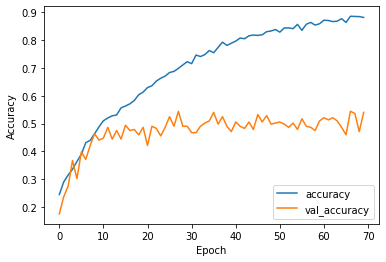

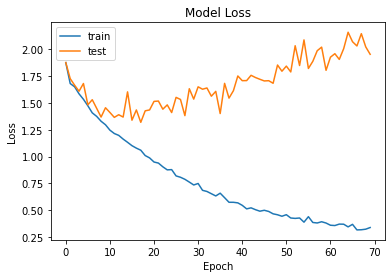

In [ ]:
plt.plot( model_history.history['acc'], label='accuracy')


plt.plot( model_history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.savefig('Initial_Model_Accuracy.png')
plt.show()
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Initial_Model_loss.png')
plt.show()

In [ ]:
def get_2D_model():
  model = Sequential()

  model.add(Conv2D(256, 5,padding='same',
                  input_shape=(128, 94, 1)))
  model.add(Activation('relu'))
  model.add(Conv2D(128, 5,padding='same'))
  model.add(Activation('relu'))
  model.add(Dropout(0.1))
  model.add(MaxPooling2D(pool_size=(8)))
  model.add(Conv2D(128, 5,padding='same',))
  model.add(Activation('relu'))
  #model.add(Conv2D(128, 5,padding='same',))
  #model.add(Activation('relu'))
  #model.add(Conv2D(128, 5,padding='same',))
  #model.add(Activation('relu'))
  #model.add(Dropout(0.2))
  model.add(Conv2D(128, 5,padding='same',))
  model.add(Activation('relu'))
  model.add(Flatten())
  model.add(Dense(6))
  model.add(Activation('softmax'))
  opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
  model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
      # model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
  model.summary()
  return model

In [ ]:
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
model = get_2D_model()
# lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# mcp_save = ModelCheckpoint(model, save_best_only=True, monitor='val_loss', mode='min')
model_history = model.fit(np.array(train_set_spectorgram), np.array(labels_train), batch_size=16, epochs=100, validation_data= (np.array(val_set_spectorgram), np.array(labels_val)))
score, acc = model.evaluate(np.array(val_set_spectorgram), np.array(labels_val), verbose=0)
trainscore, trainacc = model.evaluate(np.array(train_set_spectorgram), np.array(labels_train), verbose=0)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_43 (Conv2D)           (None, 128, 94, 256)      6656      
_________________________________________________________________
activation_28 (Activation)   (None, 128, 94, 256)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 128, 94, 128)      819328    
_________________________________________________________________
activation_29 (Activation)   (None, 128, 94, 128)      0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 128, 94, 128)      0         
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 16, 11, 128)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 11, 128)      

ValueError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

y_pred = model.predict(test_set_spectorgram)
# print(y_pred)
report=metrics.classification_report(labels_test,np.argmax(y_pred,axis=1)) 
print(report)
# print(accuracy_score(y_true=Y,y_pred=y_predict))
#print(confusion_matrix(y_test, y_pred) )
matrix = metrics.confusion_matrix(labels_test ,np.argmax(y_pred,axis=1))
print(matrix)

print('val accuracy:', acc*100)
print('train accuracy:', trainacc*100)
print("test accuracy",metrics.accuracy_score(labels_test,np.argmax(y_pred,axis=1))*100)

In [ ]:
# import glob
# from random import shuffle

# import librosa
# import numpy as np
# import pandas as pd
# from keras import optimizers, losses, activations, models
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# def get_2D_model():
#     nclass =len(np.unique(Labels))
#     inp = Input(shape=(128, 94, 1))
#     norm_inp = BatchNormalization()(inp)
#     img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu)(norm_inp)
#     img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu)(img_1)
#     img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)
#     img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)
#     img_1 = Convolution2D(128, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = GlobalMaxPool2D()(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)

#     dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
#     dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
#     dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

#     model = models.Model(inputs=inp, outputs=dense_1)
#     opt = optimizers.Adam()

#     model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
#     model.summary()
  
#     return model

In [ ]:
# from keras.callbacks import ReduceLROnPlateau
# model = get_2D_model()
# # lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# # mcp_save = ModelCheckpoint(model, save_best_only=True, monitor='val_loss', mode='min')
# model_history = model.fit(np.array(train_set_spectorgram), np.array(labels_train), batch_size=32, epochs=70, validation_data= (np.array(val_set_spectorgram), np.array(labels_val)))
# score, acc = model.evaluate(np.array(val_set_spectorgram), np.array(labels_val), verbose=0)
# print(' accuracy:', acc)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 94, 1)]      0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 94, 1)        4         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 126, 92, 16)       160       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 124, 90, 16)       2320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 30, 16)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 41, 30, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 39, 28, 32)        4640

In [ ]:
# plt.plot( model_history.history['acc'], label='accuracy')


# plt.plot( model_history.history['val_acc'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

# plt.savefig('Initial_Model_Accuracy.png')
# plt.show()
# # summarize history for loss
# plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Initial_Model_loss.png')
# plt.show()

b3d el normalization


In [ ]:
# import glob
# from random import shuffle

# import librosa
# import numpy as np
# import pandas as pd
# from keras import optimizers, losses, activations, models
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# def get_2D_model():
#     nclass =len(np.unique(Labels))
#     inp = Input(shape=(128, 94, 1))
#     norm_inp = BatchNormalization()(inp)
#     img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu)(norm_inp)
#     img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu)(img_1)
#     img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)
#     img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)
#     img_1 = Convolution2D(128, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = GlobalMaxPool2D()(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)

#     dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
#     dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
#     dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

#     model = models.Model(inputs=inp, outputs=dense_1)
#     opt = optimizers.Adam()

#     model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
#     model.summary()
  
#     return model

In [ ]:
# # from keras.callbacks import ReduceLROnPlateau
# model = get_2D_model()
# # lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# # mcp_save = ModelCheckpoint(model, save_best_only=True, monitor='val_loss', mode='min')
# model_history = model.fit(np.array(mel_spectogram_train), np.array(labels_train), batch_size=32, epochs=50, validation_data= (np.array(mel_spectogram_val), np.array(labels_val)))
# score, acc = model.evaluate(np.array(mel_spectogram_train), np.array(labels_train), verbose=0)
# print(' accuracy:', acc)

In [ ]:
# plt.plot( model_history.history['acc'], label='accuracy')


# plt.plot( model_history.history['val_acc'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

# plt.savefig('Initial_Model_Accuracy.png')
# plt.show()
# # summarize history for loss
# plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Initial_Model_loss.png')
# plt.show()

howa da

In [ ]:
# import glob
# from random import shuffle

# import librosa
# import numpy as np
# import pandas as pd
# from keras import optimizers, losses, activations, models
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# def get_2D_model():
#     nclass =len(np.unique(Labels))
#     inp = Input(shape=(128, 94, 1))
#     norm_inp = BatchNormalization()(inp)
#     img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu)(norm_inp)
#     img_1 = Convolution2D(16, kernel_size=(3, 3), activation=activations.relu)(img_1)
#     img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)
#     img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = Convolution2D(32, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)
#     img_1 = Convolution2D(128, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = GlobalMaxPool2D()(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)

#     dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
#     dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
#     dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

#     model = models.Model(inputs=inp, outputs=dense_1)
#     opt = optimizers.Adam(learning_rate=0.0001)

#     model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
#     model.summary()
  
#     return model

In [ ]:
# from keras.callbacks import ReduceLROnPlateau
# model = get_2D_model()
# # lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# # mcp_save = ModelCheckpoint(model, save_best_only=True, monitor='val_loss', mode='min')
# model_history = model.fit(np.array(train_set_spectorgram), np.array(labels_train), batch_size=32, epochs=150, validation_data= (np.array(val_set_spectorgram), np.array(labels_val)))
# score, acc = model.evaluate(np.array(val_set_spectorgram), np.array(labels_val), verbose=0)
# print(' accuracy:', acc)

In [ ]:
# plt.plot( model_history.history['acc'], label='accuracy')


# plt.plot( model_history.history['val_acc'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

# plt.savefig('Initial_Model_Accuracy.png')
# plt.show()
# # summarize history for loss
# plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Initial_Model_loss.png')
# plt.show()

In [ ]:
# import glob
# from random import shuffle

# import librosa
# import numpy as np
# import pandas as pd
# from keras import optimizers, losses, activations, models
# from keras.callbacks import ModelCheckpoint, EarlyStopping
# from keras.layers import Dense, Input, Dropout, BatchNormalization, Convolution2D, MaxPooling2D, GlobalMaxPool2D
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm
# def get_2D_model():
#     nclass =len(np.unique(Labels))
#     inp = Input(shape=(128, 94, 1))
#     norm_inp = BatchNormalization()(inp)
#     img_1 = Convolution2D(512, kernel_size=(3, 3), activation=activations.relu)(norm_inp)
#     img_1 = Convolution2D(512, kernel_size=(3, 3), activation=activations.relu)(img_1)
#     img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)
#     img_1 = Convolution2D(128, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = Convolution2D(128, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = MaxPooling2D(pool_size=(3, 3))(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)
#     img_1 = Convolution2D(128, kernel_size=3, activation=activations.relu)(img_1)
#     img_1 = GlobalMaxPool2D()(img_1)
#     img_1 = Dropout(rate=0.1)(img_1)

#     dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(img_1))
#     dense_1 = BatchNormalization()(Dense(128, activation=activations.relu)(dense_1))
#     dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

#     model = models.Model(inputs=inp, outputs=dense_1)
#     opt = optimizers.Adam(learning_rate=0.0001)

#     model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
#     model.summary()
  
#     return model

In [ ]:
# from keras.callbacks import ReduceLROnPlateau
# model = get_2D_model()
# # lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# # mcp_save = ModelCheckpoint(model, save_best_only=True, monitor='val_loss', mode='min')
# model_history = model.fit(np.array(mel_spectogram_train), np.array(labels_train), batch_size=32, epochs=20, validation_data= (np.array(mel_spectogram_val), np.array(labels_val)))
# score, acc = model.evaluate(np.array(mel_spectogram_train), np.array(labels_train), verbose=0)
# print(' accuracy:', acc)

In [ ]:
# plt.plot( model_history.history['acc'], label='accuracy')


# plt.plot( model_history.history['val_acc'], label = 'val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend(loc='lower right')

# plt.savefig('Initial_Model_Accuracy.png')
# plt.show()
# # summarize history for loss
# plt.plot(model_history.history['loss'])
# plt.plot(model_history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.savefig('Initial_Model_loss.png')
# plt.show()